In [40]:
from HeaderP import *
from scipy.interpolate import interp1d

def getcolor(vrange,cm='plasma'):
    cmap = plt.cm.get_cmap(cm)
    norm = matplotlib.colors.Normalize(vmin=min(vrange), vmax=max(vrange))
    return [cmap(norm(i)) for i in vrange]

## With new Rb

In [41]:
sub_tryRb = pd.read_pickle('NewRb.pkl')
#print(len(sub_tryRb))
sub_tryRb = sub_tryRb.loc[sub_tryRb['FEH']>-1]
#sub_tryRb = pd.read_pickle('NewRb_dip.pkl')

print(len(sub_tryRb), sum(sub_tryRb['Rb']<0)/len(sub_tryRb))

217672 0.014746958726891838


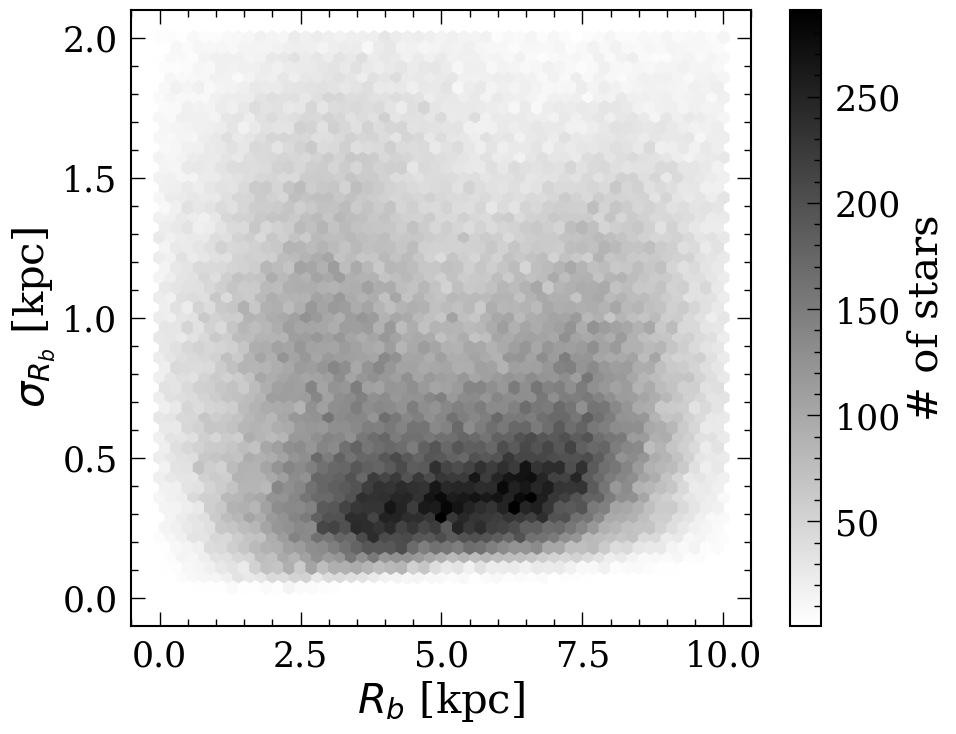

In [42]:
plt.figure(figsize=(10,8))
plt.hexbin(sub_tryRb['Rb'], sub_tryRb['Rb_err'], mincnt=1,
          cmap=plt.get_cmap('binary'),extent=(0,10,0,2),
          gridsize=50)
plt.colorbar(label='# of stars')
plt.xlabel('$R_b$ [kpc]')
plt.ylabel('$σ_{R_b}$ [kpc]')

plt.savefig('./Figures/eps/Rbirerror')
plt.savefig('./Figures/Rbirerror.png')


In [43]:
import warnings
warnings.filterwarnings('ignore')

def movingMed_time(x,y,x_window,delta_x_window):
    # medians output
    x_med=np.zeros(len(x))
    y_med=np.zeros(len(y))

    # define the boundaries of the windows
    if len(x)==0:
        return x_med,y_med
    window_min=float(min(x))
    window_max=float(window_min+delta_x_window)
    
    # max time
    maxtime=max(x)
    
    # break when time window hits the end
    while window_max<=maxtime+x_window:
        seldf=(x>=window_min) & (x<=window_max) # get points between the window
        if sum(seldf)<100:
            x_med[seldf]=np.nan
            y_med[seldf]=np.nan
        else:
            x_med[seldf]=np.median(x[seldf]) # all values for these indices are subsituded with median time
            y_med[seldf]=np.median(y[seldf]) # all values for these indices are subsituded with median flux

        # slide the window
        window_min=window_min+delta_x_window
        window_max=window_max+delta_x_window
    return x_med, y_med

In [44]:
def coldensity(x,y,binsize=50,extend=[]):
    if len(extend)==0:
        extend=(min(x),max(x),min(y),max(y))
    H, yedges, xedges = np.histogram2d(x, y, 
                                bins=(np.linspace(extend[0],extend[1],binsize),
                                        np.linspace(extend[2],extend[3],binsize)))
    """for i in trange(len(yedges)-1):
        m = (x>yedges[i])&(x<yedges[i+1])
        H[i,:] = (H[i,:]/sum(m))/max(H[i,:]/sum(m))"""
    for i in trange(len(xedges)-1):
        m = (y>xedges[i])&(y<xedges[i+1])
        H[:,i] = (H[:,i]/sum(m))/max(H[:,i]/sum(m))

    for i in range(len(H[0,:])):
        for j in range(len(H[:,0])):
            if H[j,i] == 0:
                H[j,i] = np.nan

    return yedges, xedges, H.T


100%|███████████████████████████████████████████| 29/29 [00:00<00:00, 55.39it/s]


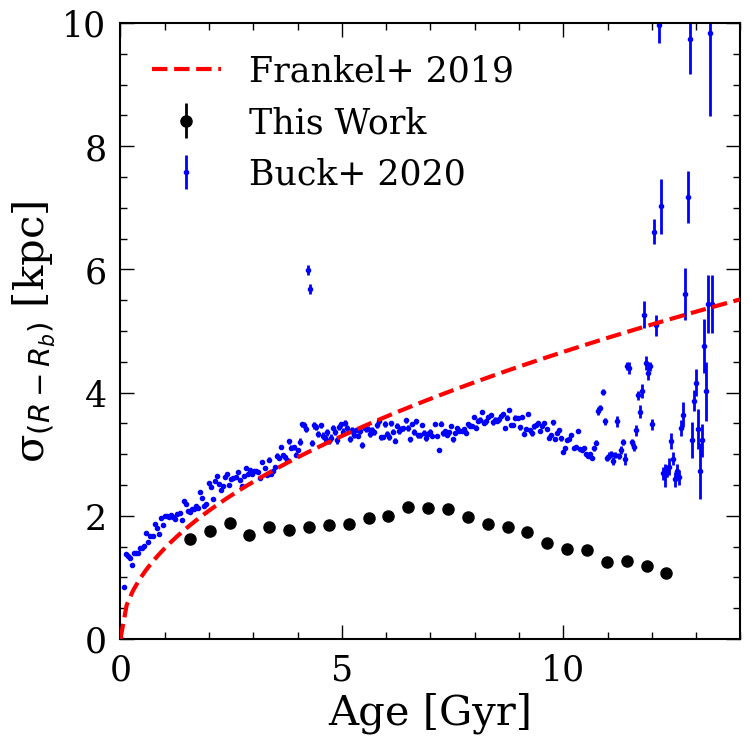

In [87]:
import astropy.uncertainty as unc

sub_tryRb['R_err'] = (sub_tryRb['PARALLAX'])**-2*(sub_tryRb['PARALLAX_ERROR'])


agebincalc_rm = np.linspace(0,13,30)
mean_dr = np.zeros(len(agebincalc_rm)-1)
mean_dr_err = np.zeros(len(agebincalc_rm)-1)

sub_tryRb['AGE_sca'] = sub_tryRb['AGE']
sub_tryRb = sub_tryRb.loc[sub_tryRb['AGE_ERR']<np.diff(agebincalc_rm)[0]]
sub_tryRb_sub = sub_tryRb
sub_tryRb_sub = sub_tryRb.loc[abs(sub_tryRb['R_GUIDING'])<20]
sub_tryRb_sub = sub_tryRb_sub.loc[sub_tryRb_sub['Rb']<20]
sub_tryRb_sub = sub_tryRb_sub.loc[sub_tryRb_sub['FEH']>-1]
sub_tryRb_sub = sub_tryRb_sub.loc[abs(sub_tryRb_sub['R']-8.2)<0.2]

for i in trange(len(agebincalc_rm)-1):
    sub_tryRb_sing = sub_tryRb_sub.loc[(sub_tryRb_sub['AGE_sca']>agebincalc_rm[i])&(sub_tryRb_sub['AGE_sca']<agebincalc_rm[i+1])]
    #mean_dr[i] = np.std(sub_tryRb_sing['Rb_new']-sub_tryRb_sing['R'])    
    #mean_dr_err[i] = mean_dr[i]/(len(sub_tryRb_sing)-1)
    
    sub_tryRb_sing = sub_tryRb_sing.dropna(subset=['Rb','R_err','R_GUIDING'])
    sub_tryRb_sing = sub_tryRb_sing.loc[sub_tryRb_sing['R_err']<1]
    
    if len(sub_tryRb_sing)<30:
        mean_dr[i] = np.nan
        mean_dr_err[i] = np.nan
        continue
        
    Rbdist = unc.normal(sub_tryRb_sing['Rb'].values, 
                     std=sub_tryRb_sing['Rb_err'].values, 
                     n_samples=1000)
    Rdist = unc.normal(sub_tryRb_sing['R'].values, 
                     std=sub_tryRb_sing['R_err'].values, 
                     n_samples=1000)
    
    drdist = np.std(Rbdist-Rdist)
    
    mean_dr[i] = drdist.pdf_mean()
    mean_dr_err[i] = drdist.pdf_var()
    
    
plt.figure(figsize=(8,8))
dR_sim = pd.read_pickle('BuckMigration.pkl')

plt.errorbar((agebincalc_rm[1:]+agebincalc_rm[:-1])/2, mean_dr,
             yerr=mean_dr_err, fmt='ko', label='This Work', 
            markersize=8)
plt.plot(np.linspace(0,14,100), 
         3.9*np.sqrt(np.linspace(0,14,100)/7), 
         'r--', label='Frankel+ 2019', zorder=10,
        linewidth=3)

m = (dR_sim['NoS']>30)
plt.errorbar(dR_sim['meanage'][m], dR_sim['meandR'][m],
             yerr=dR_sim['meadR_err'][m], fmt='bo', 
             label='Buck+ 2020', markersize=3)

plt.xlim([0,14])
plt.ylim([0,10])
plt.xlabel('Age [Gyr]')
plt.ylabel('σ$_{(R-R_b)}$ [kpc]')
plt.legend()

plt.savefig('Figures/eps/migrationStr',bbox_inches='tight')
plt.savefig('Figures/migrationStr.png',bbox_inches='tight')

1490


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 1715.34it/s]


34734


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 765.03it/s]


17224


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 1322.58it/s]


2088


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 1823.47it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


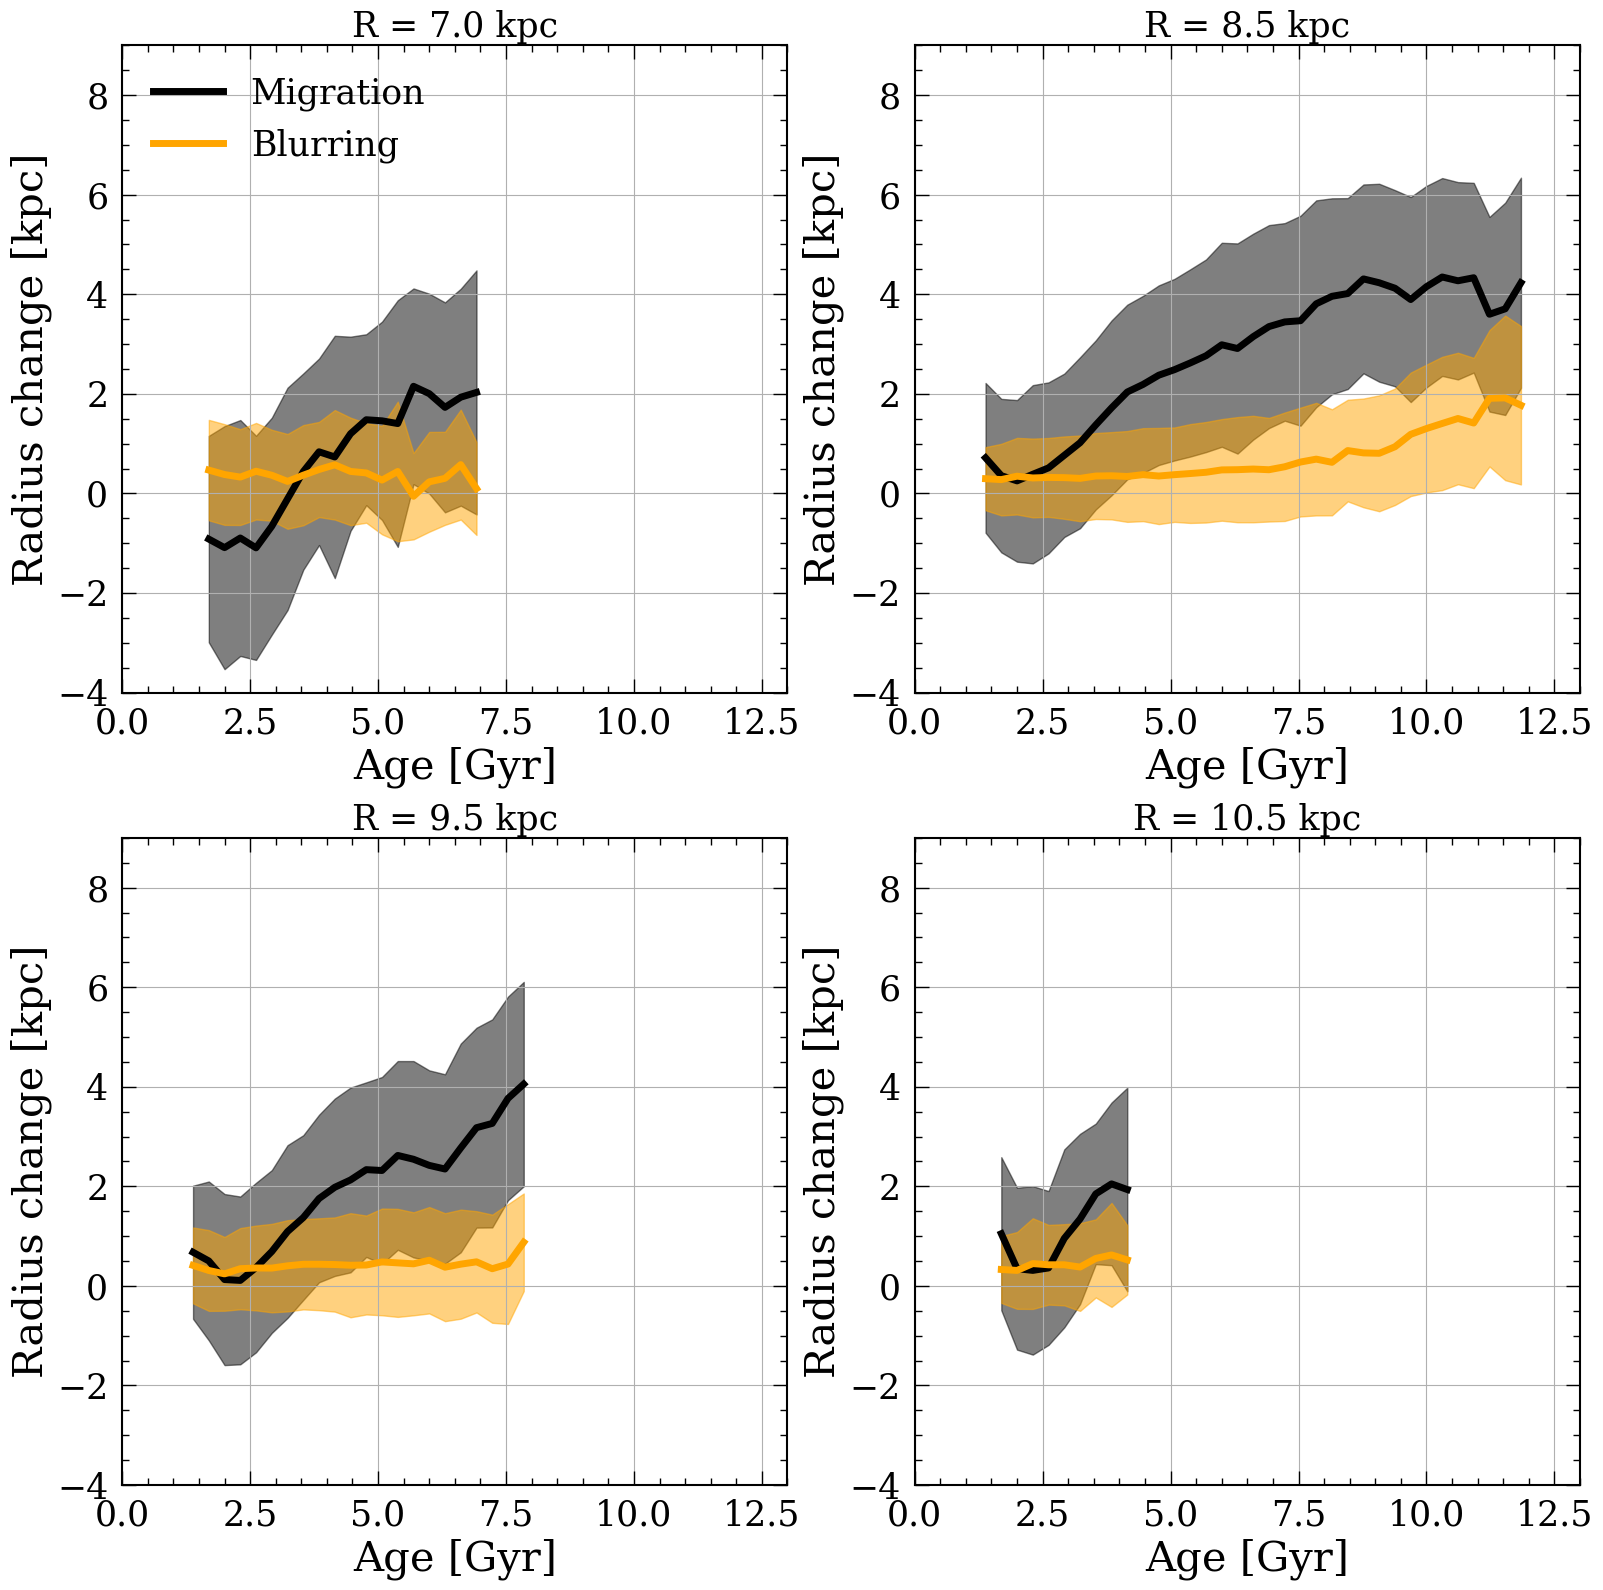

In [59]:
import astropy.uncertainty as unc

sub_tryRb = pd.read_pickle('NewRb.pkl')

agebincalc_rm = np.linspace(0,12,40)
sub_tryRb = sub_tryRb.loc[sub_tryRb['AGE_ERR']<np.diff(agebincalc_rm)[0]]
sub_tryRb['AGE_sca'] = sub_tryRb['AGE']
sub_tryRb_sub_all = sub_tryRb.loc[abs(sub_tryRb['R_GUIDING'])<20]
sub_tryRb_sub_all = sub_tryRb_sub_all.loc[sub_tryRb_sub_all['Rb']<20]
sub_tryRb_sub_all = sub_tryRb_sub_all.loc[sub_tryRb_sub_all['FEH']>-1]

plt.figure(figsize=(16,16))
count = 1
for rsel in [7.0,8.5,9.5,10.5]:
    sub_tryRb_sub = sub_tryRb_sub_all.loc[abs(sub_tryRb_sub_all['R']-rsel)<0.5]
    print(len(sub_tryRb_sub))

    mean_dr = np.zeros(len(agebincalc_rm)-1)
    std_dr = np.zeros(len(agebincalc_rm)-1)

    mean_blr = np.zeros(len(agebincalc_rm)-1)
    std_blr = np.zeros(len(agebincalc_rm)-1)

    for i in trange(len(agebincalc_rm)-1):
        sub_tryRb_sing = sub_tryRb_sub.loc[(sub_tryRb_sub['AGE']>agebincalc_rm[i])&(sub_tryRb_sub['AGE']<agebincalc_rm[i+1])]

        sub_tryRb_sing = sub_tryRb_sing.dropna(subset=['Rb','R_GUIDING'])

        if len(sub_tryRb_sing)<30:
            mean_dr[i] = np.nan
            std_dr[i] = np.nan

            mean_blr[i] = np.nan
            std_blr[i] = np.nan
            continue

        mean_dr[i] = np.mean(sub_tryRb_sing['R_GUIDING']-sub_tryRb_sing['Rb'])
        std_dr[i] = np.std(sub_tryRb_sing['R_GUIDING']-sub_tryRb_sing['Rb'])
        mean_blr[i] = np.mean(sub_tryRb_sing['R']-sub_tryRb_sing['R_GUIDING'])
        std_blr[i] = np.std(sub_tryRb_sing['R']-sub_tryRb_sing['R_GUIDING'])


    plt.subplot(2,2,count)
    """plt.errorbar((agebincalc_rm[1:]+agebincalc_rm[:-1])/2, mean_dr,
                 yerr=std_dr, fmt='.',  color='k', alpha=0.5,
                linewidth=10)"""
    plt.plot((agebincalc_rm[1:]+agebincalc_rm[:-1])/2, mean_dr,'-',
             color='k', linewidth=5, label='Migration')
    plt.fill_between((agebincalc_rm[1:]+agebincalc_rm[:-1])/2,
                    mean_dr-std_dr, mean_dr+std_dr,color='k',
                    alpha=0.5)

    """plt.errorbar((agebincalc_rm[1:]+agebincalc_rm[:-1])/2, mean_blr,
                 yerr=std_blr, fmt='.',  color='orange', alpha=0.5,
                linewidth=10)"""
    plt.plot((agebincalc_rm[1:]+agebincalc_rm[:-1])/2, mean_blr,'-',
             color='orange', linewidth=5, label='Blurring')
    plt.fill_between((agebincalc_rm[1:]+agebincalc_rm[:-1])/2,
                    mean_blr-std_blr, mean_blr+std_blr,color='orange',
                    alpha=0.5)
    plt.grid()

    plt.xlim([0,13])
    plt.ylim([-4,9])
    plt.xlabel('Age [Gyr]')
    plt.ylabel('Radius change [kpc]')
    if count==1:
        plt.legend(loc=2)
    plt.title('R = '+str(rsel)+' kpc', fontsize=25)
    count = count+1
plt.tight_layout()

plt.savefig('Figures/eps/migrationStr',bbox_inches='tight')
plt.savefig('Figures/migrationStr.png',bbox_inches='tight')

array([[<AxesSubplot:title={'center':'VZ'}>,
        <AxesSubplot:title={'center':'VT'}>],
       [<AxesSubplot:title={'center':'VR'}>, <AxesSubplot:>]],
      dtype=object)

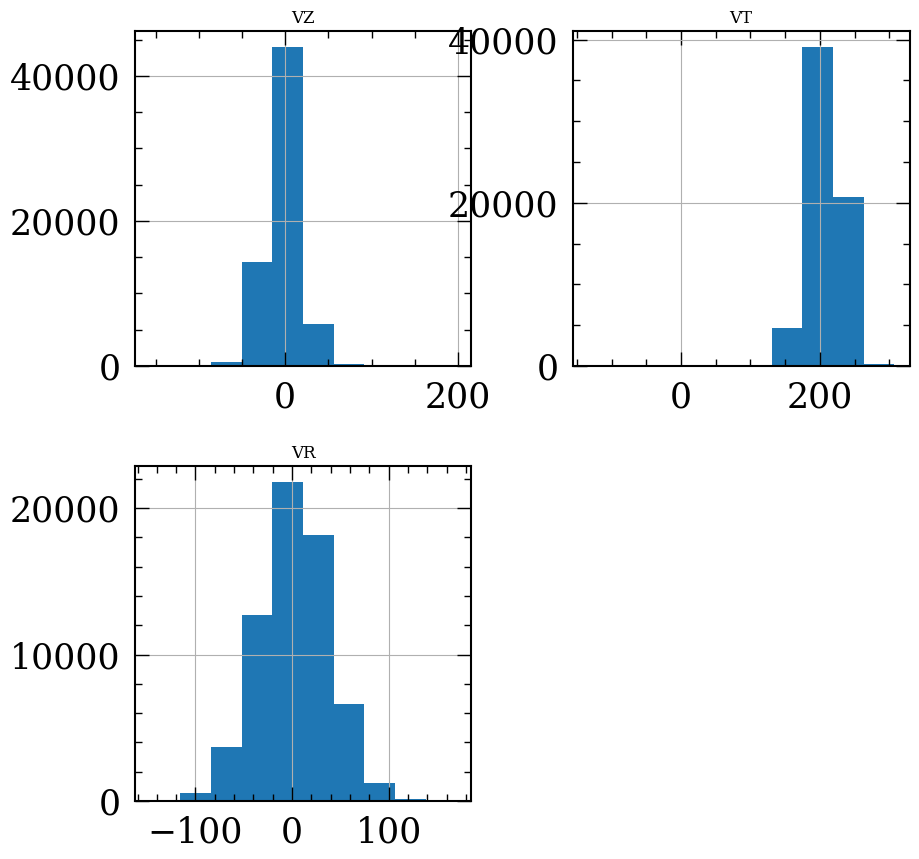

In [60]:
sub_tryRb = sub_tryRb.loc[abs(sub_tryRb['VZ'])<200]
sub_tryRb = sub_tryRb.loc[abs(sub_tryRb['VT'])<500]
sub_tryRb = sub_tryRb.loc[abs(sub_tryRb['VR'])<500]
sub_tryRb = sub_tryRb.loc[abs(sub_tryRb['ECC'])<0.5]
sub_tryRb[['VZ','VT','VR']].hist()

In [75]:
def avr(age, r, vz, rbin=np.linspace(6,12,4), agebin=np.linspace(0,14,10)):
    colors = getcolor(range(len(rbin)+1))
    avrs = np.zeros((len(rbin)-1, len(agebin)-1))
    for i in range(len(rbin)-1):
        m = (r>rbin[i])&(r<rbin[i+1])
        age_r, r_r, vz_r = age[m], r[m], vz[m]
        for j in range(len(agebin)-1):
            m2 = (age_r>agebin[j])&(age_r<agebin[j+1])
            if sum(m2)<50:
                avrs[i,j]=np.nan
            else:
                vz_r_age = vz_r[m2]
                avrs[i,j] = 1.5*sum(abs(vz_r_age-np.median(vz_r_age)))/sum(m2)
    return (agebin[:-1]+agebin[1:])/2, (rbin[:-1]+rbin[1:])/2, avrs


sub_tryRb = sub_tryRb.loc[abs(sub_tryRb['Z'])<1].reset_index(drop=True)
ages, rs, avrs_z = avr( sub_tryRb['Rb_new'].values, sub_tryRb['AGE'].values,
                       sub_tryRb['VZ'].values, 
                     rbin=np.linspace(2,12,7), agebin=np.linspace(2,20,20))

ages, rs, avrs_phi = avr(sub_tryRb['Rb_new'].values, sub_tryRb['AGE'].values,
                         sub_tryRb['VT'].values, 
                     rbin=np.linspace(2,12,7), agebin=np.linspace(2,20,20))

ages, rs, avrs_r = avr(sub_tryRb['Rb_new'].values, sub_tryRb['AGE'].values,
                       sub_tryRb['VR'].values, 
                     rbin=np.linspace(2,12,7), agebin=np.linspace(2,20,20))



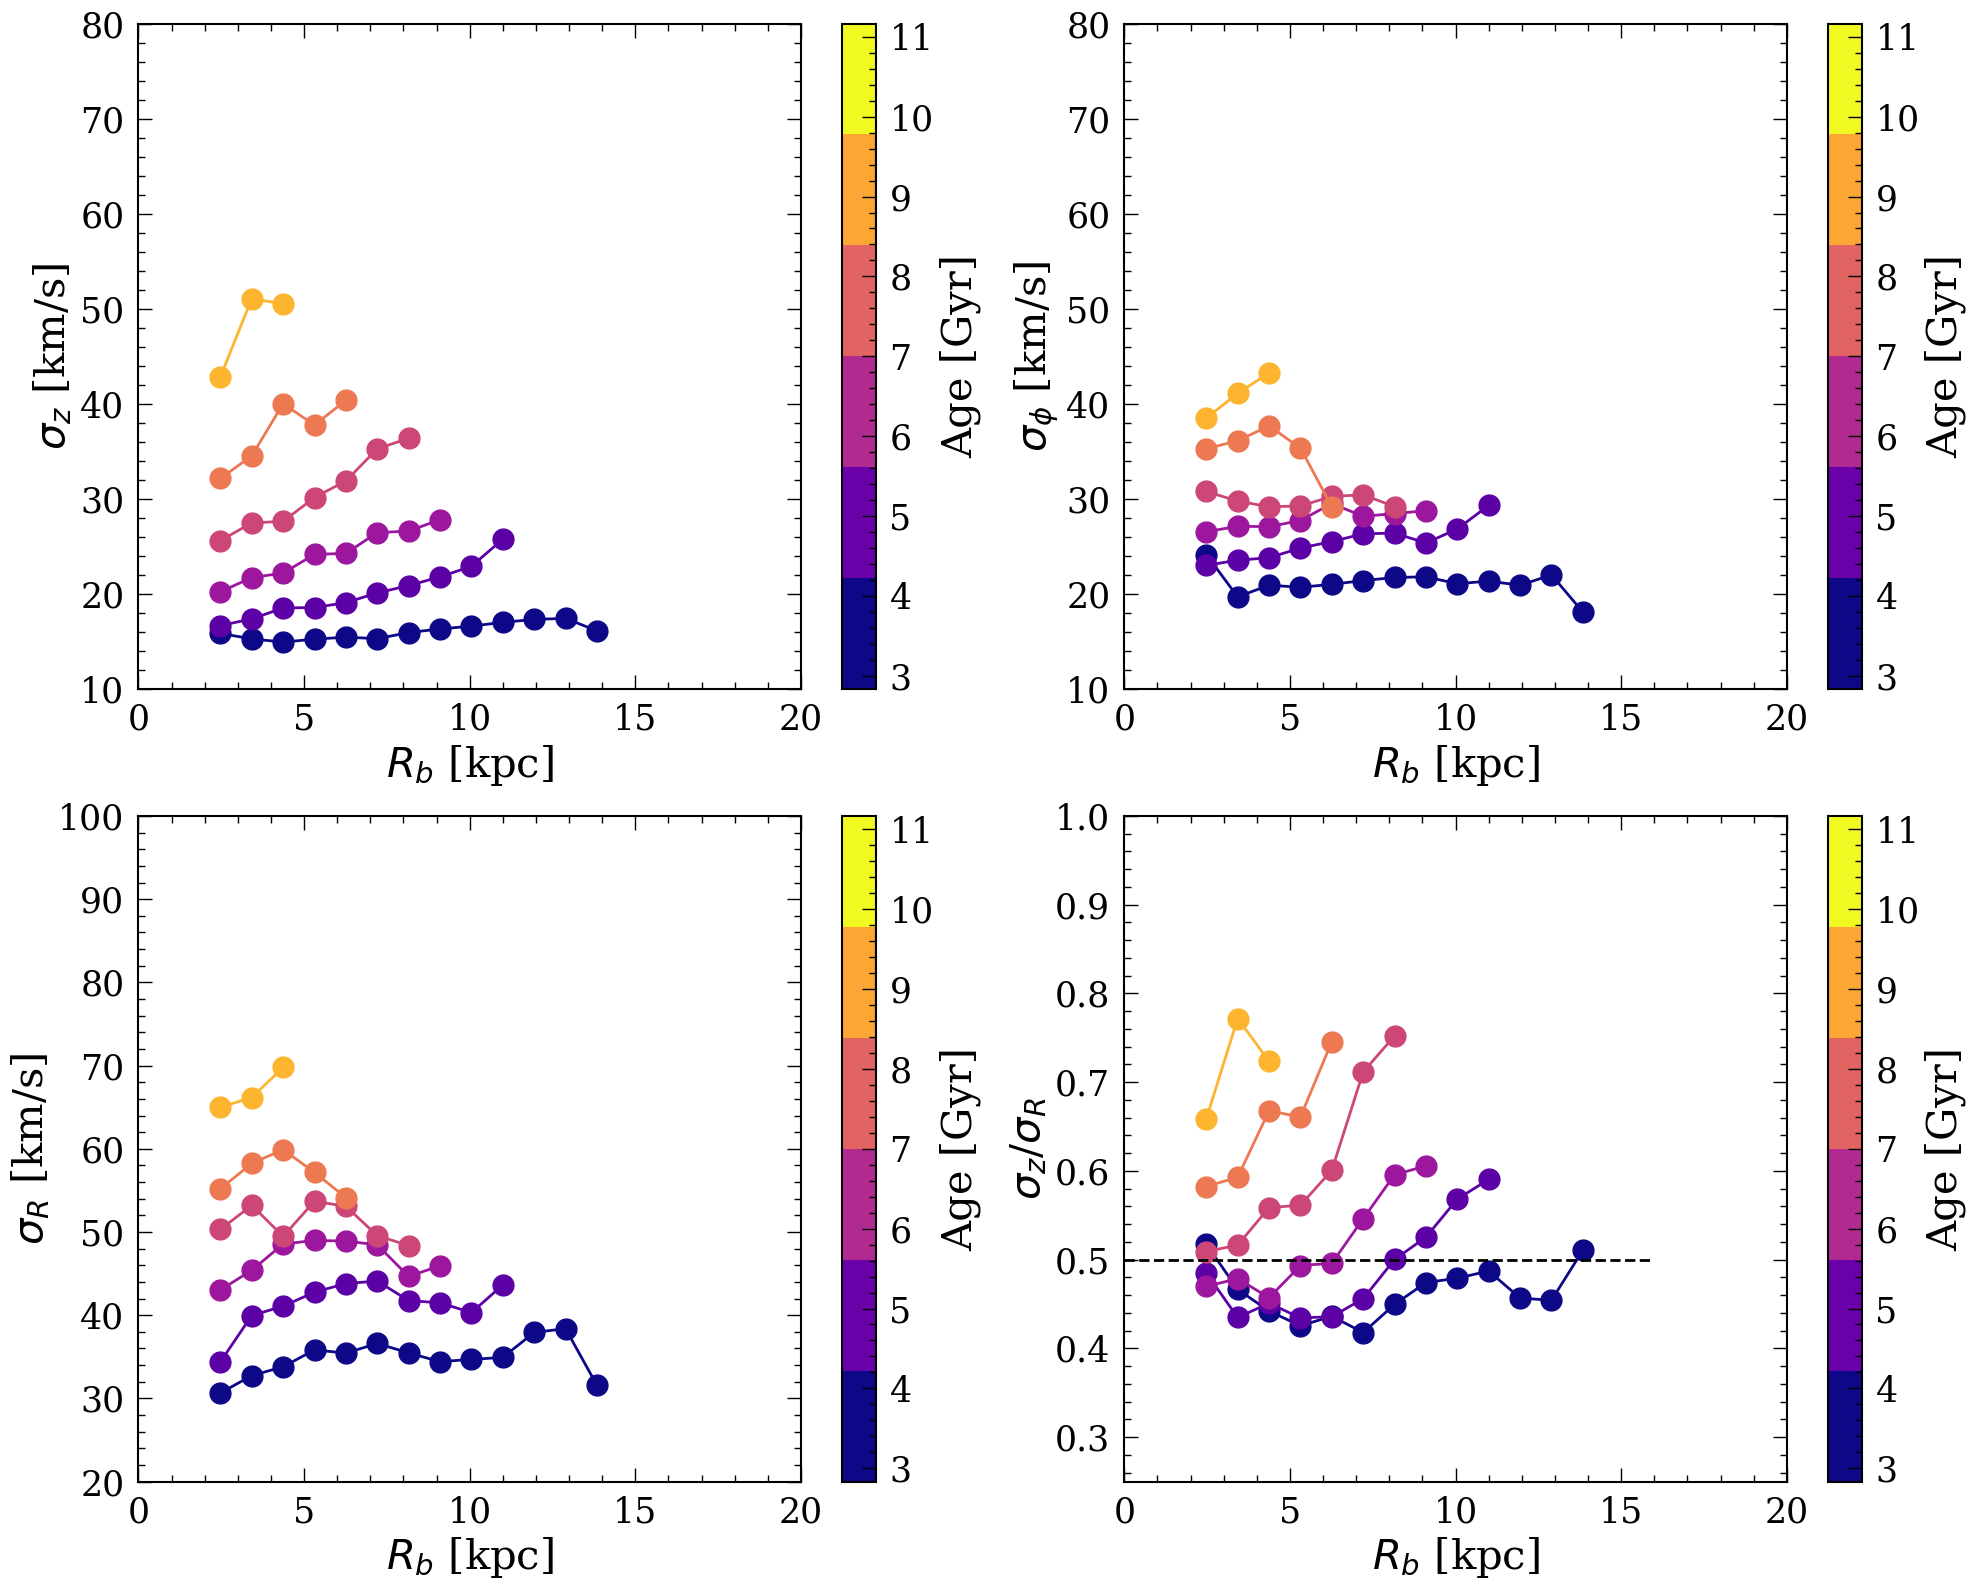

In [76]:

colors = getcolor(np.linspace(2,12,7))

plt.figure(figsize=(20,16))
plt.subplot(2,2,1)
for i in range(len(rs)):
    plt.plot(ages, avrs_z[i,:], 'o-', color=colors[i], label='Age = %.2f Gyr'%rs[i],
            markersize=15)
    plt.xlabel('$R_b$ [kpc]')
    plt.ylabel('$σ_z$ [km/s]')
plt.scatter(-100, -100, c=1, vmin=min(rs), vmax=max(rs), cmap=plt.get_cmap('plasma',6))
plt.ylim([10, 80])
plt.xlim([0,20])
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
#plt.legend()


plt.subplot(2,2,2)
for i in range(len(rs)):
    plt.plot(ages, avrs_phi[i,:], 'o-', color=colors[i], label='Age = %.2f Gyr'%rs[i],
            markersize=15)
    plt.xlabel('$R_b$ [kpc]')
    plt.ylabel('$σ_ϕ$ [km/s]')
plt.ylim([10, 80])
plt.xlim([0,20])
plt.scatter(-100, -100, c=1, vmin=min(rs), vmax=max(rs), cmap=plt.get_cmap('plasma',6))
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
#plt.legend()



plt.subplot(2,2,3)
for i in range(len(rs)):
    plt.plot(ages, avrs_r[i,:], 'o-', color=colors[i], label='Age = %.2f Gyr'%rs[i],
            markersize=15)
    plt.xlabel('$R_b$ [kpc]')
    plt.ylabel('$σ_R$ [km/s]')
plt.ylim([20, 100])
plt.xlim([0,20])
plt.scatter(-100, -100, c=1, vmin=min(rs), vmax=max(rs), cmap=plt.get_cmap('plasma',6))
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
#plt.legend()



plt.subplot(2,2,4)
for i in range(len(rs)):
    plt.plot(ages, avrs_z[i,:]/avrs_r[i,:], 'o-', color=colors[i], label='Age = %.2f Gyr'%rs[i],
            markersize=15)
    plt.xlabel('$R_b$ [kpc]')
    plt.ylabel('$σ_z$/$σ_R$')
plt.ylim([0.25, 1])
plt.xlim([0,20])
plt.scatter(-100, -100, c=1, vmin=min(rs), vmax=max(rs), cmap=plt.get_cmap('plasma',6))
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
#plt.legend()

plt.plot([0,16], [0.5,0.5], 'k--')



plt.tight_layout()

In [77]:
#sub['Rmean'] = (sub['R_PERI']+sub['R_APO'])/2

sub_tryRb = sub_tryRb.loc[abs(sub_tryRb['Z'])<1].reset_index(drop=True)
ages, rs, avrs_z = avr(sub_tryRb['AGE'].values, sub_tryRb['Rb_new'].values, 
                       sub_tryRb['VZ'].values, 
                     rbin=np.linspace(2,15,5), agebin=np.linspace(0,12,13))

ages, rs, avrs_phi = avr(sub_tryRb['AGE'].values, sub_tryRb['Rb_new'].values, 
                         sub_tryRb['VT'].values, 
                     rbin=np.linspace(2,15,5), agebin=np.linspace(0,12,13))

ages, rs, avrs_r = avr(sub_tryRb['AGE'].values, sub_tryRb['Rb_new'].values, 
                       sub_tryRb['VR'].values, 
                     rbin=np.linspace(2,15,5), agebin=np.linspace(0,12,13))

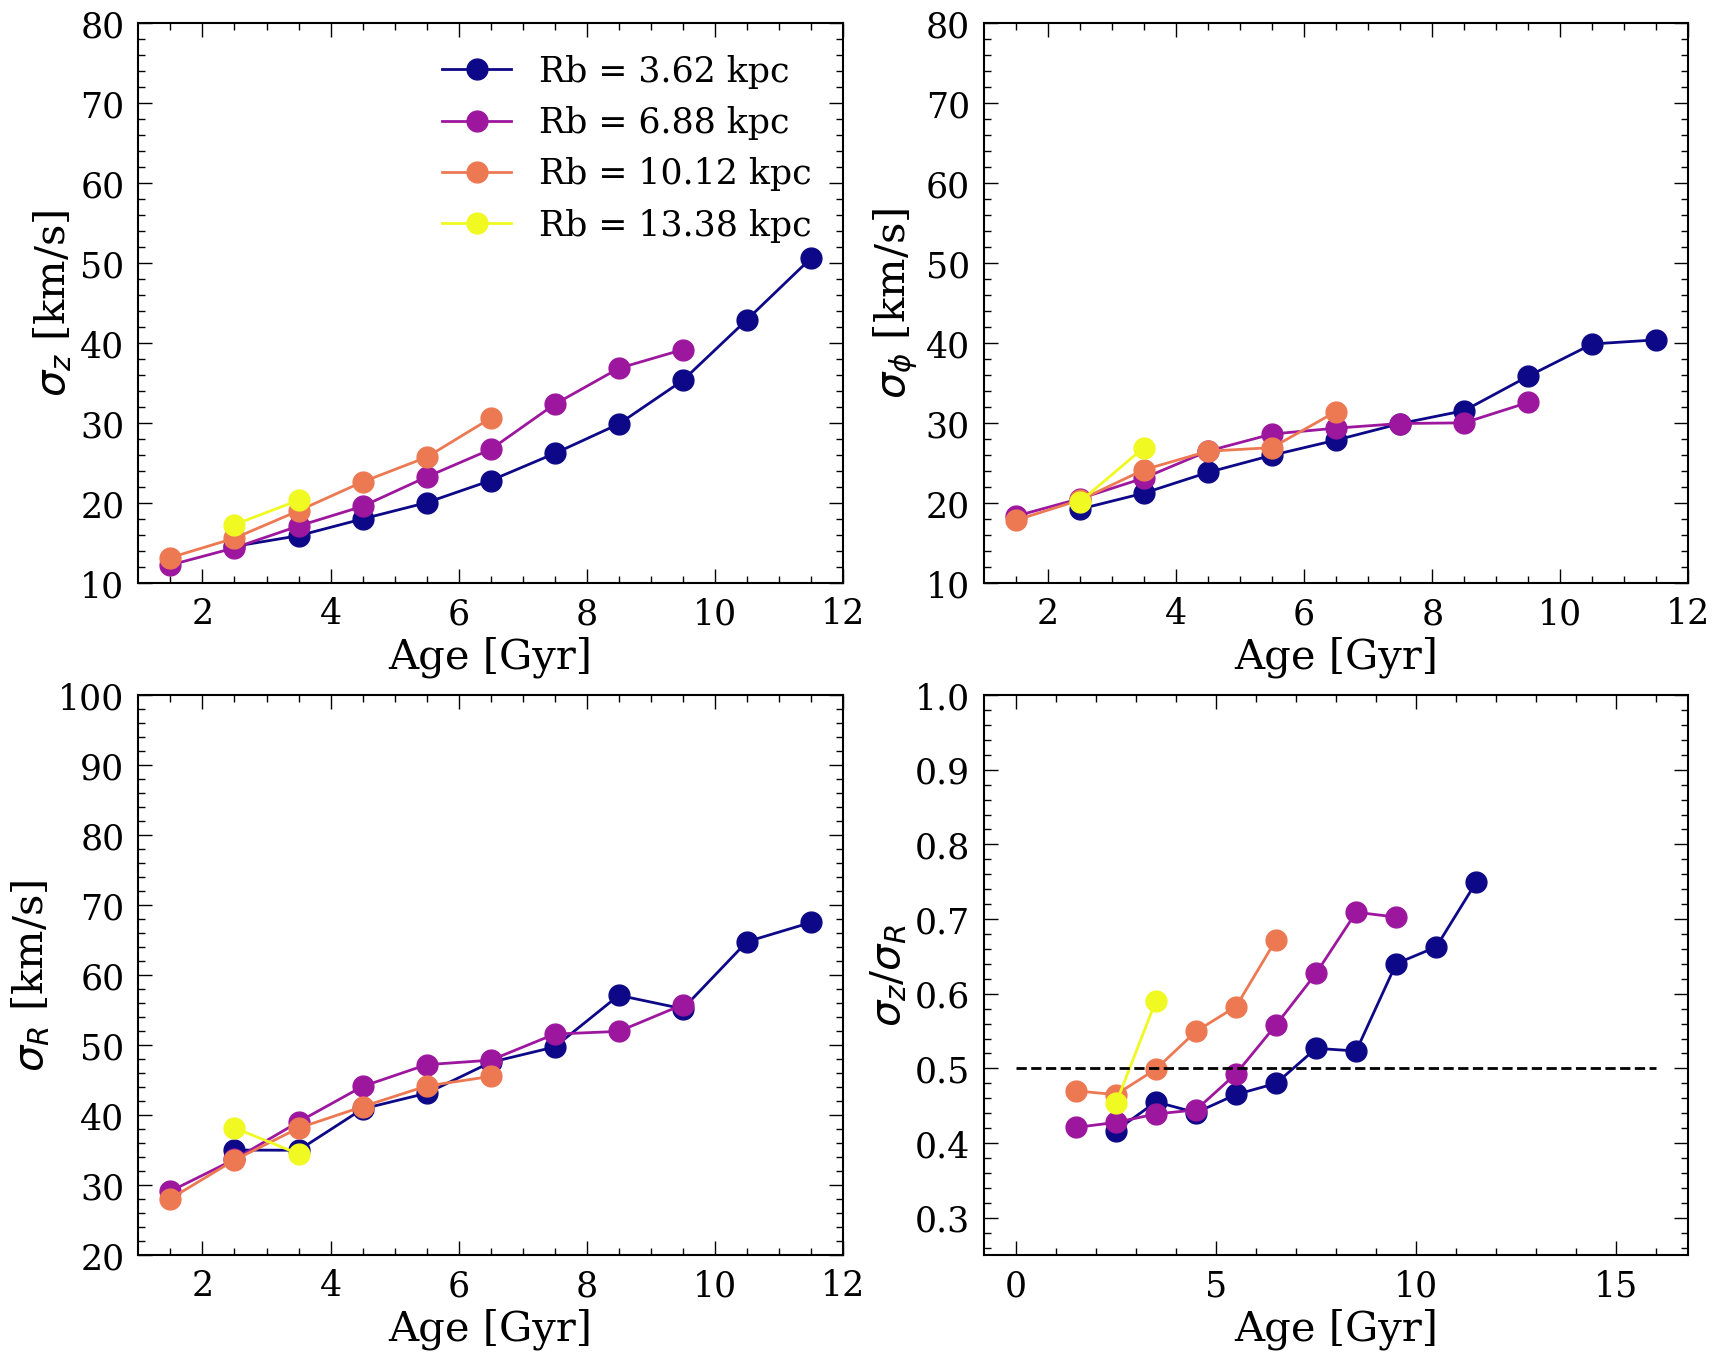

In [78]:


plt.figure(figsize=(20,16))
colors = getcolor(rs)

plt.subplot(2,2,1)
for i in range(len(rs)):
    plt.plot(ages, avrs_z[i,:], 'o-', color=colors[i], label='Rb = %.2f kpc'%rs[i],
            markersize=15)
    plt.xlabel('Age [Gyr]')
    plt.ylabel('$σ_z$ [km/s]')
plt.ylim([10, 80])
plt.legend()



plt.subplot(2,2,2)
for i in range(len(rs)):
    plt.plot(ages, avrs_phi[i,:], 'o-', color=colors[i], label='Rb = %.2f kpc'%rs[i],
            markersize=15)
    plt.xlabel('Age [Gyr]')
    plt.ylabel('$σ_ϕ$ [km/s]')
plt.ylim([10, 80])



plt.subplot(2,2,3)
for i in range(len(rs)):
    plt.plot(ages, avrs_r[i,:], 'o-', color=colors[i], label='Rb = %.2f kpc'%rs[i],
            markersize=15)
    plt.xlabel('Age [Gyr]')
    plt.ylabel('$σ_R$ [km/s]')
plt.ylim([20, 100])



plt.subplot(2,2,4)
for i in range(len(rs)):
    plt.plot(ages, avrs_z[i,:]/avrs_r[i,:], 'o-', color=colors[i], label='Rb = %.2f kpc'%rs[i],
            markersize=15)
    plt.xlabel('Age [Gyr]')
    plt.ylabel('$σ_z$/$σ_R$')
plt.ylim([0.25, 1])

plt.plot([0,16], [0.5,0.5], 'k--')






Text(0, 0.5, 'Rb')

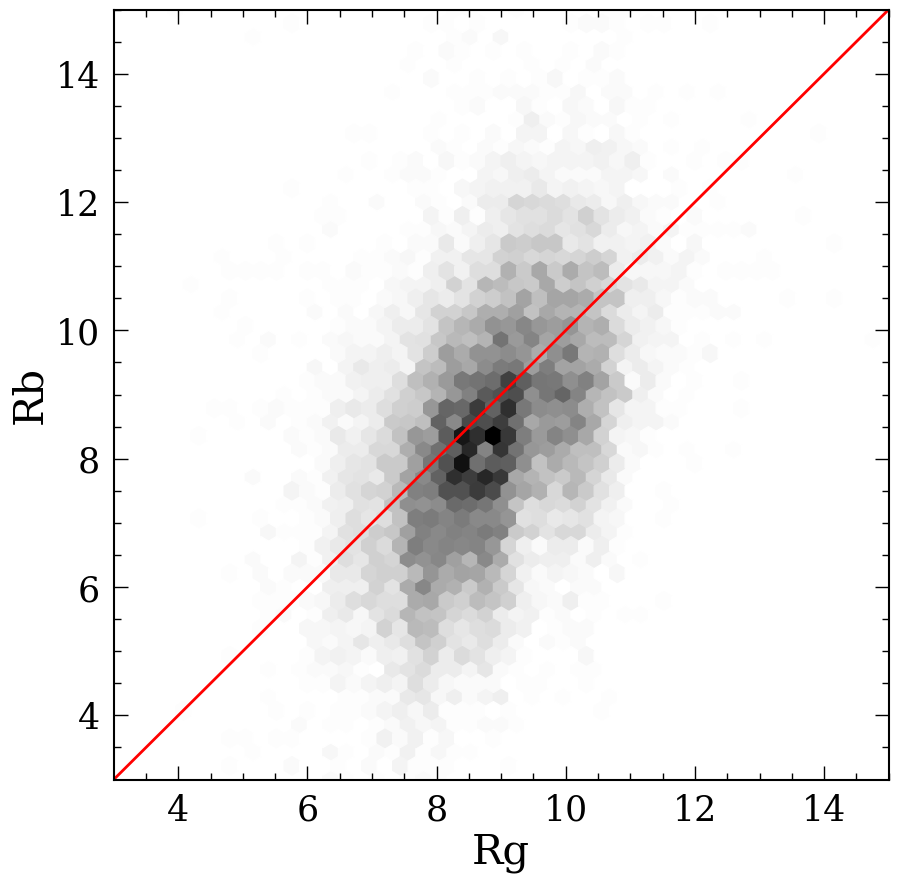

In [74]:
sub_tryRb_plt = sub_tryRb.loc[sub_tryRb['AGE']<3]
plt.hexbin(sub_tryRb_plt['R_GUIDING'], sub_tryRb_plt['Rb_new'], cmap='binary',
          extent=(3,15,3,15),gridsize=50)
plt.plot([0,15],[0,15],'r-')
plt.xlim([3, 15])
plt.ylim([3, 15])
plt.xlabel('Rg')
plt.ylabel('Rb')

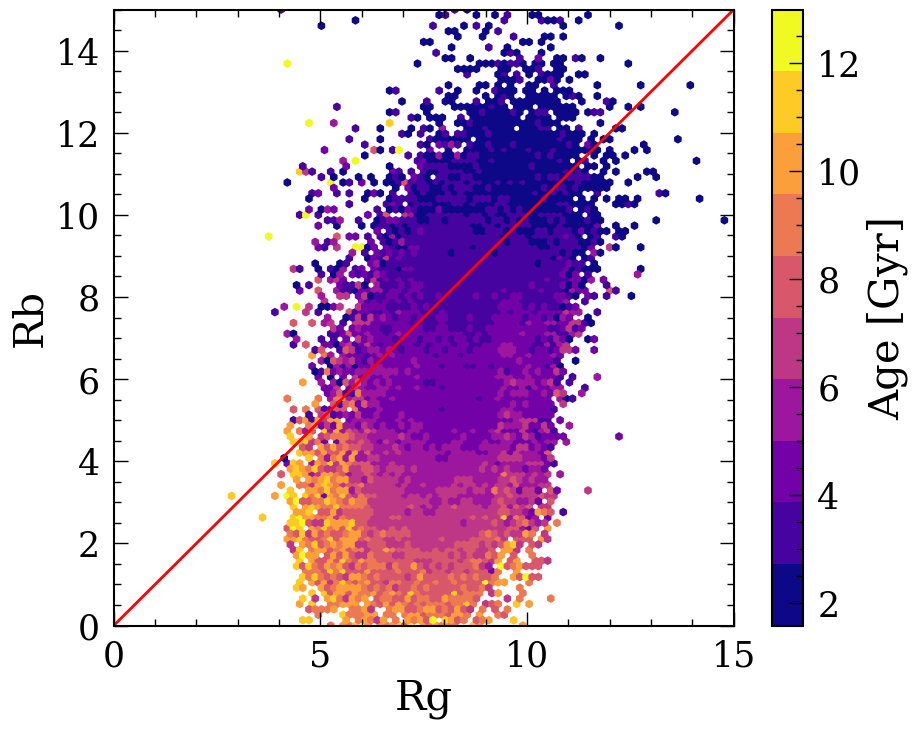

In [94]:
plt.figure(figsize=(10,8))
sub_tryRb_plt = sub_tryRb.loc[sub_tryRb['AGE']<13]
plt.hexbin(sub_tryRb_plt['R_GUIDING'], sub_tryRb_plt['Rb_new'], 
           C=sub_tryRb_plt['AGE'],cmap=plt.get_cmap('plasma', 10),
          extent=(0,15,0,15),gridsize=100,reduce_C_function=np.median)
plt.plot([0,15],[0,15],'r-')
plt.xlim([0, 15])
plt.ylim([0, 15])
plt.xlabel('Rg')
plt.ylabel('Rb')
plt.colorbar(label='Age [Gyr]')